# 라이브러리 불러오기

In [ ]:
import pandas as pd
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas_datareader.data as pdr
import numpy as np
from xgboost import plot_importance, plot_tree
from numpy import asarray
from xgboost import XGBRegressor
from math import sqrt
from matplotlib import pyplot
from datetime import date
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline


import warnings
import plotly.graph_objects as go
import chart_studio.plotly as py
import plotly.offline as pyo
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

warnings.filterwarnings(action='ignore')

# 데이터 불러오기

In [ ]:
## 데이터 불러오기
train = pd.read_csv("data/train.csv", encoding = 'euc-kr')
train['DateTime'] = pd.to_datetime(train['DateTime'])
train['date'] = train.DateTime.dt.date

new_train= pd.read_csv("data/2차_train.csv", encoding = 'euc-kr')
new_train['DateTime'] = pd.to_datetime(new_train['DateTime'])
new_train['date'] = new_train.DateTime.dt.date

## 시간 합산
train = pd.DataFrame(train.groupby('date').sum().reset_index())
new_train = pd.DataFrame(new_train.groupby('date').sum().reset_index())

In [ ]:
## 1차 train과 2차 train 합치기
train = pd.concat([train, new_train]).reset_index(drop = True)

# train의 date도 같은 형식으로 뽑기
train['date'] = pd.to_datetime(train['date']).dt.date

train.tail()

,date,사용자,세션,신규방문자,페이지뷰
817,2020-12-04,3189,3068,743,75730
818,2020-12-05,2055,2019,497,47638
819,2020-12-06,2119,2077,460,46914
820,2020-12-07,2979,2988,753,77443
821,2020-12-08,3033,2990,772,68857


In [ ]:
submission = pd.read_csv("data/submission.csv", encoding = 'euc-kr')

In [ ]:
login_info = pd.read_csv('data/new_login_info.csv', index_col=0)
competition_info = pd.read_csv('data/new_competition_info.csv', index_col=0, encoding='cp949')
user_info = pd.read_csv('data/new_user_info.csv', index_col=0)
submission_info = pd.read_csv('data/new_submission_info.csv', index_col=0).dropna(how = 'all')

# active_made

In [ ]:
## id와 c_time만 남김
made_info = user_info[['id','c_time']]

## c_time과 id 모두 같은 곳에서 결측치기에 모두 삭제
made_info_dropna = made_info.dropna().copy()
made_info_dropna['c_time'] = pd.to_datetime(made_info_dropna['c_time'])

# 연월일로 나타내기
made_info_dropna['day'] = made_info_dropna['c_time'].apply(lambda x : x.strftime('%Y-%m-%d') )
made_info_dropna.day = pd.to_datetime(made_info_dropna.day).dt.date
made_info_dropna = made_info_dropna[made_info_dropna.day>=date(2018,9,9)].reset_index(drop = True)

# 아이디 생성한 사용자
active_made = made_info_dropna.groupby(['day'])['id'].nunique().reset_index()
active_made.day = pd.to_datetime(active_made.day).dt.date
active_made.rename(columns = {'id':'active_made'}, inplace = True)
active_made.tail(2)

,day,active_made
840,2021-01-07,81
841,2021-01-08,82


# active login user & all login user

In [ ]:
### active_login_user
## user_id와 c_time 변수를 제외한 나머지 모든 변수 제거
## 중간중간 있는 login_id나 user_id의 결측치도 모두 제거
login_info_drop_na = login_info[['user_id','c_time']].dropna().copy()
login_info_drop_na['c_time'] = pd.to_datetime(login_info_drop_na['c_time'])
## 연월일로 나타내기
login_info_drop_na['day'] = login_info_drop_na['c_time'].apply(lambda x : x.strftime('%Y-%m-%d') )
## 실제 로그인한 사용자가 몇 명인가
active_login_user = login_info_drop_na.groupby(['day'])['user_id'].nunique().reset_index()
active_login_user['day'] = pd.to_datetime(active_login_user['day']).dt.date
active_login_user.rename(columns = {'user_id':'active_login_user'}, inplace = True)
active_login_user



### all_login_user
## platform과 browser의 결측치가 많아 변수 제거 -> 유의미한 변수도 아님
## 중간중간 있는 login_id나 user_id의 결측치도 모두 제거
login_info_drop_na2 = login_info[['user_id','c_time']].copy()
## 총 사용자를 확인 하기 위해 결측치 다 채우기
login_info_drop_na2['user_id'].fillna(0, inplace = True)
login_info_drop_na2 = login_info_drop_na2.dropna()
login_info_drop_na2['c_time'] = pd.to_datetime(login_info_drop_na2['c_time'])
## 연월일로 나타내기
login_info_drop_na2['day'] = login_info_drop_na2['c_time'].apply(lambda x : x.strftime('%Y-%m-%d') )
## 해당 일에 로그인 횟수가 총 몇 번인가
all_login_user = login_info_drop_na2.groupby(['day'])['user_id'].count().reset_index()
all_login_user['day'] = pd.to_datetime(all_login_user['day']).dt.date
all_login_user.rename(columns = {'user_id':'all_login_user'}, inplace = True)
all_login_user.tail(2)

,day,all_login_user
837,2021-01-07,480
838,2021-01-08,449


# 제출 정보 추가 데이터 확인

In [ ]:
### team_id별 user_id별 제출 수 뽑기
sub_info = submission_info.copy()

sub_info_dropna = sub_info[['team_id','user_id','c_time']].dropna().copy()
sub_info_dropna.c_time = pd.to_datetime(sub_info_dropna.c_time)
# 연월로 나타내기
sub_info_dropna['day'] = sub_info_dropna['c_time'].apply(lambda x : x.strftime('%Y-%m-%d') )
sub_info_dropna = sub_info_dropna[(sub_info_dropna['day']>='2018-09-09')]


## 실제 제출한 사용자가 몇 명인가 : user_id
active_sub_user = sub_info_dropna.groupby(['day'])['user_id'].nunique().reset_index()
active_sub_user.day = pd.to_datetime(active_sub_user.day).dt.date
active_sub_user.rename(columns = {'user_id':'active_sub_user'}, inplace = True)
active_sub_user


## 팀 아이디로 정리 : 
active_sub_team = sub_info_dropna.groupby(['day'])['team_id'].nunique().reset_index()
active_sub_team.day = pd.to_datetime(active_sub_team.day).dt.date
active_sub_team.rename(columns = {'team_id':'active_sub_team'}, inplace = True)
active_sub_team.tail(2)

,day,active_sub_team
777,2021-01-07,174
778,2021-01-08,178


In [ ]:
### team_id별 user_id별 제출 수 뽑기
sub_info = submission_info.copy()

sub_info_all = sub_info[['team_id','user_id','c_time']].copy()
sub_info_all.c_time = pd.to_datetime(sub_info_all.c_time)
sub_info_all[['team_id','user_id']] = sub_info_all[['team_id','user_id']].fillna(0)


# 연월로 나타내기
sub_info_all['day'] = sub_info_all['c_time'].apply(lambda x : x.strftime('%Y-%m-%d') )
sub_info_all = sub_info_all[(sub_info_all['day']>='2018-09-09')]

## 제출한 총 수
all_sub_user = sub_info_all.groupby(['day'])['user_id'].count().reset_index()
all_sub_user.day = pd.to_datetime(all_sub_user.day).dt.date
all_sub_user.rename(columns = {'user_id':'all_sub_user'}, inplace = True)

## 팀 아이디로 제출한 총 수
all_sub_team = sub_info_all.groupby(['day'])['team_id'].count().reset_index()
all_sub_team.day = pd.to_datetime(all_sub_team.day).dt.date
all_sub_team.rename(columns = {'team_id':'all_sub_team'}, inplace = True)
all_sub_team.tail(2)

,day,all_sub_team
777,2021-01-07,412
778,2021-01-08,408


---------------

# 공통된 요일 기준 병합

In [ ]:
### 제출수 요일이 가장 적으므로 '제출'을 기준으로 병합
print(active_made.shape)
print(active_login_user.shape)
print(all_login_user.shape)
print(active_sub_user.shape)
print(active_sub_team.shape)
print(all_sub_user.shape)
print(all_sub_team.shape)

(842, 2)
(839, 2)
(839, 2)
(779, 2)
(779, 2)
(779, 2)
(779, 2)


In [ ]:
df_list = [all_login_user, active_sub_user, active_sub_team, all_sub_user, all_sub_team]
df = pd.merge(active_made, active_login_user, how = 'inner', on = 'day')
for i in df_list:
    df = pd.merge(df, i, how = 'inner', on = 'day')
    
# df = df.rename(columns = {'id':'active_made',
#                    'user_id_x':'active_login_user',
#                    'user_id_y':'all_login_user',
#                    'user_id_x':'active_sub_user',
#                    'team_id_x':'active_sub_team',
#                    'user_id_y':'all_sub_user',
#                    'team_id_y':'all_sub_team'})

# df = df.set_index('day')
df = df.rename(columns = {'day':'date'})
df.tail()

,date,active_made,active_login_user,all_login_user,active_sub_user,active_sub_team,all_sub_user,all_sub_team
752,2021-01-04,117,387,477,129,118,283,283
753,2021-01-05,101,365,453,131,120,268,268
754,2021-01-06,100,555,639,197,178,430,430
755,2021-01-07,81,420,480,197,174,412,412
756,2021-01-08,82,358,449,205,178,408,408


In [ ]:
trn = pd.merge(train, df, how = 'inner', on = 'date')
trn.shape

(726, 12)

In [ ]:
train.tail(2)

,date,사용자,세션,신규방문자,페이지뷰
820,2020-12-07,2979,2988,753,77443
821,2020-12-08,3033,2990,772,68857


---------------

# 데이터 분할

In [ ]:
trn_x = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,11,8))].iloc[:,5:]
trn_y_user = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,11,8))].reset_index(drop = True).iloc[:,1]
trn_y_sess = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,11,8))].reset_index(drop = True).iloc[:,2]
trn_y_new = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,11,8))].reset_index(drop = True).iloc[:,3]
trn_y_page = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,11,8))].reset_index(drop = True).iloc[:,4]

In [ ]:
test_x = trn[trn.date == date(2020,11,16)].reset_index(drop = True).iloc[:,5:]
test_y_user = trn[trn.date == date(2020,11,16)].reset_index(drop = True).iloc[:,1]
test_y_sess = trn[trn.date == date(2020,11,16)].reset_index(drop = True).iloc[:,2]
test_y_new = trn[trn.date == date(2020,11,16)].reset_index(drop = True).iloc[:,3]
test_y_page = trn[trn.date == date(2020,11,16)].reset_index(drop = True).iloc[:,4]

In [ ]:
print(trn_x.shape)
print(trn_y_user.shape)
print()
print(test_x.shape)
print(test_y_user.shape)

(313, 7)
(313,)

(1, 7)
(1,)


## train 기간 설정

In [ ]:
##### 최고기록과 정답과의 비교

plot_data = [
    go.Scatter(
        x=trn.date,
        y=trn_y_user,
        name = 'test_y_user'
    )
    
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'who is best'
    },
    yaxis = {
        'title' : 'user Counts'
    },
    title = 'sub user Counts',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)


# 모델 피팅

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

extra_tree1 = ExtraTreesRegressor(random_state = 40,
                               n_estimators = 500)
extra_tree2 = ExtraTreesRegressor(random_state = 40,
                               n_estimators = 500)
extra_tree3 = ExtraTreesRegressor(random_state = 40,
                               n_estimators = 500)
extra_tree4 = ExtraTreesRegressor(random_state = 40,
                               n_estimators = 500)

In [ ]:
## 11/16 예측
extra_tree1.fit(trn_x, trn_y_user)
extra_tree2.fit(trn_x, trn_y_sess)
extra_tree3.fit(trn_x, trn_y_new)
extra_tree4.fit(trn_x, trn_y_page)

ExtraTreesRegressor(n_estimators=500, random_state=40)

In [ ]:
print(test_y_user)
print(test_y_sess)
print(test_y_new)
print(test_y_page)

0    5200
Name: 사용자, dtype: int64
0    5079
Name: 세션, dtype: int64
0    1124
Name: 신규방문자, dtype: int64
0    142311
Name: 페이지뷰, dtype: int64


In [ ]:
print('#### 11/16 사용자 ####')
print(extra_tree1.predict(test_x))

print('#### 11/16 세션 ####')
print(extra_tree2.predict(test_x))

print('#### 11/16 신규방문자 ####')
print(extra_tree3.predict(test_x))

print('#### 11/16 세션 ####')
print(extra_tree4.predict(test_x))

#### 11/16 사용자 ####
[4762.968]
#### 11/16 세션 ####
[4747.102]
#### 11/16 신규방문자 ####
[1360.366]
#### 11/16 세션 ####
[133381.62]


## <지금까지 총 평>
- 11/16 예측 잘 함
- 차이가 얼마 안 나 보임

-----------------

# 2차 train 기간 예측(리더보드 구간)

In [ ]:
trn_x = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,11,8))].iloc[:,5:]
trn_y_user = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,11,8))].reset_index(drop = True).iloc[:,1]
trn_y_sess = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,11,8))].reset_index(drop = True).iloc[:,2]
trn_y_new = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,11,8))].reset_index(drop = True).iloc[:,3]
trn_y_page = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,11,8))].reset_index(drop = True).iloc[:,4]

In [ ]:
test_x = trn[(trn.date > date(2020,11,8))].reset_index(drop = True).iloc[:,5:]
test_y_user = trn[(trn.date > date(2020,11,8)) & (trn.date < date(2020, 12, 9))].reset_index(drop = True).iloc[:,1]
test_y_sess = trn[(trn.date > date(2020,11,8)) & (trn.date < date(2020, 12, 9))].reset_index(drop = True).iloc[:,2]
test_y_new = trn[(trn.date > date(2020,11,8)) & (trn.date < date(2020, 12, 9))].reset_index(drop = True).iloc[:,3]
test_y_page = trn[(trn.date > date(2020,11,8)) & (trn.date < date(2020, 12, 9))].reset_index(drop = True).iloc[:,4]

In [ ]:
print(trn_x.shape)
print(trn_y_user.shape)
print()
print(test_x.shape)
print(test_y_user.shape)

(313, 7)
(313,)

(30, 7)
(30,)


# 모델 피팅

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

extra_tree1 = ExtraTreesRegressor(random_state = 40,
                               n_estimators = 500,
                                 max_depth = 10)
extra_tree2 = ExtraTreesRegressor(random_state = 40,
                               n_estimators = 500,
                                 max_depth = 10)
extra_tree3 = ExtraTreesRegressor(random_state = 40,
                               n_estimators = 500,
                                 max_depth = 10)
extra_tree4 = ExtraTreesRegressor(random_state = 40,
                               n_estimators = 500,
                                 max_depth = 10)

In [ ]:
## 11/16 예측
extra_tree1.fit(trn_x, trn_y_user)
extra_tree2.fit(trn_x, trn_y_sess)
extra_tree3.fit(trn_x, trn_y_new)
extra_tree4.fit(trn_x, trn_y_page)

ExtraTreesRegressor(max_depth=10, n_estimators=500, random_state=40)

In [ ]:
print('#### 11/16 사용자 ####')
pred_user = pd.Series(extra_tree1.predict(test_x))

print('#### 11/16 세션 ####')
pred_sess = pd.Series(extra_tree2.predict(test_x))

print('#### 11/16 신규방문자 ####')
pred_new = pd.Series(extra_tree3.predict(test_x))

print('#### 11/16 세션 ####')
pred_page = pd.Series(extra_tree4.predict(test_x))

#### 11/16 사용자 ####
#### 11/16 세션 ####
#### 11/16 신규방문자 ####
#### 11/16 세션 ####


# 2차 train 구간 확인

In [ ]:
##### 최고기록과 정답과의 비교

plot_data = [
    go.Scatter(
        x=new_train.index,
        y=new_train['사용자'],
        name = 'new_train'
    ),
    go.Scatter(
        x=pred_user.index,
        y=pred_user,
        name = 'pred_user'
    )
    
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'who is best'
    },
    yaxis = {
        'title' : 'user Counts'
    },
    title = 'sub user Counts',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)


In [ ]:
##### 최고기록과 정답과의 비교

plot_data = [
    go.Scatter(
        x=new_train.index,
        y=new_train['세션'],
        name = 'new_train'
    ),
    go.Scatter(
        x=pred_sess.index,
        y=pred_sess,
        name = 'pred_sess'
    )
    
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'who is best'
    },
    yaxis = {
        'title' : 'sess Counts'
    },
    title = 'sub sess Counts',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)


In [ ]:
##### 최고기록과 정답과의 비교

plot_data = [
    go.Scatter(
        x=new_train.index,
        y=new_train['신규방문자'],
        name = 'new_train'
    ),
    go.Scatter(
        x=pred_new.index,
        y=pred_new,
        name = 'pred_new'
    )
    
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'who is best'
    },
    yaxis = {
        'title' : 'new Counts'
    },
    title = 'sub new Counts',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)


In [ ]:
plot_data = [
    go.Scatter(
        x=new_train.index,
        y=new_train['페이지뷰'],
        name = 'new_train'
    ),
    go.Scatter(
        x=pred_page.index,
        y=pred_page,
        name = 'pred_new'
    )
    
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'who is best'
    },
    yaxis = {
        'title' : 'page Counts'
    },
    title = 'sub page Counts',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)


In [ ]:
## 이후 날짜도 합치기
sub = pd.concat([pred_user, pred_sess, pred_new, pred_page], axis = 1)
sub.rename(columns = {0:'사용자',1:'세션',2:'신규방문자',3:'페이지뷰'}, inplace = True)
sub.tail()

,사용자,세션,신규방문자,페이지뷰
25,2682.701210,2604.078347,577.850483,71586.196095
26,1616.896389,1602.036217,342.480802,45518.582945
27,1998.166748,1956.005092,420.423239,46993.963737
28,3199.513124,3155.827544,847.772877,84486.238458
29,3093.241593,3078.241002,859.086551,80788.962742


## lstm과 비교

In [ ]:
lstm_best = pd.read_csv('data/lstm공휴일(최고기록의 재료).csv', encoding = 'euc-kr')
lstm_best = lstm_best.iloc[:30, :]

now_best = pd.read_csv('data/best공휴일+xgb_new.csv', encoding = 'euc-kr')
# now_best = now_best.iloc[:30, :]

In [ ]:
##### ;기록들과 비교

plot_data = [
    go.Scatter(
        x=new_train.index,
        y=new_train['페이지뷰'],
        name = 'new_train'
    ),
    go.Scatter(
        x=pred_page.index,
        y=pred_page,
        name = 'pred_new'
    ),
    go.Scatter(
        x=now_best.index,
        y=now_best['페이지뷰'],
        name = 'now_best'
    )
    
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'who is best'
    },
    yaxis = {
        'title' : 'page Counts'
    },
    title = 'sub page Counts',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)


------------------

# 2차 train 기간 예측(제출을 위해 61일치 예측)

In [ ]:
trn_x = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,11,8))].iloc[:,5:]
trn_y_user = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,11,8))].reset_index(drop = True).iloc[:,1]
trn_y_sess = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,11,8))].reset_index(drop = True).iloc[:,2]
trn_y_new = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,11,8))].reset_index(drop = True).iloc[:,3]
trn_y_page = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,11,8))].reset_index(drop = True).iloc[:,4]

In [ ]:
test_x = df[(df.date > date(2020,11,8)) & (df.date < date(2021, 1, 9))].reset_index(drop = True).iloc[:,1:]
# test_y_user = trn[(trn.date > date(2020,11,8)) & (trn.date < date(2021, 1, 9))].reset_index(drop = True).iloc[:,1]
# test_y_sess = trn[(trn.date > date(2020,11,8)) & (trn.date < date(2021, 1, 9))].reset_index(drop = True).iloc[:,2]
# test_y_new = trn[(trn.date > date(2020,11,8)) & (trn.date < date(2021, 1, 9))].reset_index(drop = True).iloc[:,3]
# test_y_page = trn[(trn.date > date(2020,11,8)) & (trn.date < date(2021, 1, 9))].reset_index(drop = True).iloc[:,4]

In [ ]:
print(trn_x.shape)
print(trn_y_user.shape)
print()
print(test_x.shape)

(313, 7)
(313,)

(61, 7)


# 모델 피팅

# Grid Search CV_61

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV

param_grid={'max_depth':[8,9,10,11,12],
            'n_estimators':[400, 450, 500, 550, 600, 650, 700, 750],
           'random_state':[40]}

In [ ]:
## shuffle

cv=KFold(n_splits=5, random_state=40, shuffle = True)

In [ ]:
extra_tree = ExtraTreesRegressor()

grid1=GridSearchCV(extra_tree, param_grid=param_grid, cv=cv, n_jobs=-1)
grid2=GridSearchCV(extra_tree, param_grid=param_grid, cv=cv, n_jobs=-1)
grid3=GridSearchCV(extra_tree, param_grid=param_grid, cv=cv, n_jobs=-1)
grid4=GridSearchCV(extra_tree, param_grid=param_grid, cv=cv, n_jobs=-1)

## 그리드 서치 피팅
grid1.fit(trn_x, trn_y_user)
grid2.fit(trn_x, trn_y_sess)
grid3.fit(trn_x, trn_y_new)
grid4.fit(trn_x, trn_y_page)

print('final params', grid1.best_params_)   # 최적의 파라미터 값 출력
print('final params', grid2.best_params_)   # 최적의 파라미터 값 출력
print('final params', grid3.best_params_)   # 최적의 파라미터 값 출력
print('final params', grid4.best_params_)   # 최적의 파라미터 값 출력

grid1_extra = grid1.best_estimator_
grid2_extra = grid2.best_estimator_
grid3_extra = grid3.best_estimator_
grid4_extra = grid4.best_estimator_

KeyboardInterrupt: 

In [ ]:
## 61일치 각 Y별로 Grid Search CV
good61_params1 = {'max_depth': 9, 'n_estimators': 500, 'random_state': 40}
good61_params2 = {'max_depth': 9, 'n_estimators': 500, 'random_state': 40}
good61_params3 = {'max_depth': 8, 'n_estimators': 650, 'random_state': 40}
good61_params4 = {'max_depth': 11, 'n_estimators': 450, 'random_state': 40}


## best 파라미터 입력
good61_grid1 = ExtraTreesRegressor(**good61_params1)
good61_grid2 = ExtraTreesRegressor(**good61_params2)
good61_grid3 = ExtraTreesRegressor(**good61_params3)
good61_grid4 = ExtraTreesRegressor(**good61_params4)

## 피팅
good61_grid1.fit(trn_x, trn_y_user)
good61_grid2.fit(trn_x, trn_y_sess)
good61_grid3.fit(trn_x, trn_y_new)
good61_grid4.fit(trn_x, trn_y_page)

## 예측
pred_user_61 = pd.Series(good61_grid1.predict(test_x))
pred_sess_61 = pd.Series(good61_grid2.predict(test_x))
pred_new_61 = pd.Series(good61_grid3.predict(test_x))
pred_page_61 = pd.Series(good61_grid4.predict(test_x))

In [ ]:
## 날짜 합치기
sub = pd.concat([submission.DateTime, pred_user_61, pred_sess_61, pred_new_61, pred_page_61], axis = 1)
sub.set_index('DateTime', inplace = True)
sub.rename(columns = {0:'사용자',1:'세션',2:'신규방문자',3:'페이지뷰'}, inplace = True)
sub = sub.astype(int)
sub.tail()

,사용자,세션,신규방문자,페이지뷰
DateTime,,,,
2021-01-04,4124,4174,1123,110144
2021-01-05,3993,3977,1026,106828
2021-01-06,4844,4982,1450,142237
2021-01-07,4497,4477,1177,122406
2021-01-08,3958,3941,959,108816


In [ ]:
sub.to_csv('data/61일치 extra(1.69).csv', encoding = 'euc_kr',index=True)

In [ ]:
##### 기록들과 비교

plot_data = [
    go.Scatter(
        x=new_train.date,
        y=new_train['사용자'],
        name = 'new_train'
    ),
    go.Scatter(
        x=sub.index,
        y=sub['사용자'],
        name = 'grid_61'
    ),
    go.Scatter(
        x=now_best.index,
        y=now_best['사용자'],
        name = 'now_best'
    )
    
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'who is best'
    },
    yaxis = {
        'title' : 'page Counts'
    },
    title = 'sub page Counts',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)


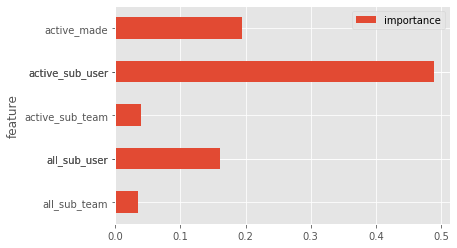

In [ ]:
imp = pd.DataFrame({'feature': trn_x.columns, 'importance': grid1_extra.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

# 리더보드 구간 결과 뽑기

In [ ]:
sub = pd.concat([pred_user_grid, pred_sess_grid, pred_new_grid, pred_page_grid], axis = 1)
pred = sub.iloc[:30,:]

w0 = 1095.2146464646464
w1 = 1086.7285353535353
w2 = 268.07070707070704
w3 = 24236.194444444445

def dacon_rmse(true, pred):
    # true.shape // (N,4)
    # pred.shape // (N,4)
    # w0, w1, w2, w3 <= train.csv의 사용자 수, 세션 수, 신규 방문자 수, 페이지 뷰 수 4가지 항목별 평균값
    score = np.sqrt(np.mean(np.square(true.iloc[:,1] - pred.iloc[:,0]))) / w0 +\
            + np.sqrt(np.mean(np.square(true.iloc[:,2] - pred.iloc[:,1]))) / w1 +\
            + np.sqrt(np.mean(np.square(true.iloc[:,3] - pred.iloc[:,2]))) / w2 +\
            + np.sqrt(np.mean(np.square(true.iloc[:,4] - pred.iloc[:,3]))) / w3 
    return score

In [ ]:
# rmse 확인
ex_sub = sub.iloc[:30,:]
dacon_rmse(new_train, ex_sub)
#ex_sub

5.747123890365199

In [ ]:
new_train.tail()

,date,사용자,세션,신규방문자,페이지뷰
25,2020-12-04,3189,3068,743,75730
26,2020-12-05,2055,2019,497,47638
27,2020-12-06,2119,2077,460,46914
28,2020-12-07,2979,2988,753,77443
29,2020-12-08,3033,2990,772,68857


In [ ]:
# rmse 확인
dacon_rmse(new_train, pred)

1.6929510453814365

In [ ]:

sub = sub.reset_index(drop = True)

In [ ]:
now_best.head()

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,3574,3536,863,91716
1,2020-11-10,4272,4466,1204,117366
2,2020-11-11,3738,3698,886,93758
3,2020-11-12,4136,3800,921,115696
4,2020-11-13,3405,3229,786,84806


In [ ]:
## 원채 최고 기록과 평균을 내어서 확인
# now_best_test = now_best.iloc[:30,1:]
# now_best_test.rename(columns = {'사용자':0,'세션':1,'신규방문자':2,'페이지뷰':3}, inplace = True)
pred2 = (now_best+sub)/2
# dacon_rmse(new_train, pred2)
pred2.head()

,DateTime,사용자,세션,신규방문자,페이지뷰
0,NaN,4073.5,4036.5,1026.0,103951.0
1,NaN,4038.0,4041.0,1039.5,107570.0
2,NaN,4219.5,4154.0,1041.5,106498.0
3,NaN,3994.5,3758.5,909.0,105237.5
4,NaN,3677.0,3504.0,857.0,93487.0


In [ ]:
sub.shape

(31, 4)

In [ ]:
pred2.to_csv('data/stacking_extra+best_score_최신.csv', encoding = 'euc_kr',index=True)

------------------

# 1차+2차로 private 구간 예측

In [ ]:
trn_x = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,12,8))].iloc[:,5:]
trn_y_user = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,12,8))].reset_index(drop = True).iloc[:,1]
trn_y_sess = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,12,8))].reset_index(drop = True).iloc[:,2]
trn_y_new = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,12,8))].reset_index(drop = True).iloc[:,3]
trn_y_page = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,12,8))].reset_index(drop = True).iloc[:,4]

In [ ]:
## 테스트 데이터
test_x = df[(df.date > date(2020,12,8)) & (df.date < date(2021, 1, 9))].reset_index(drop = True).iloc[:,1:]

In [ ]:
print(trn_x.shape)
print(trn_y_user.shape)
print()
print(test_x.shape)

(343, 7)
(343,)

(31, 7)


# Grid Search CV

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV

param_grid={'max_depth':[8,9,10,11],
            'n_estimators':[400, 450, 500, 550, 600, 650, 700, 750],
            'min_samples_leaf':[1,2],
            'min_samples_split':[2,3,4],
           'random_state':[40]}

In [ ]:
## shuffle
cv=KFold(n_splits=5, random_state=40, shuffle = True)

In [ ]:
extra_tree = ExtraTreesRegressor()

grid1=GridSearchCV(extra_tree, param_grid=param_grid, cv=cv, n_jobs=-1)
grid2=GridSearchCV(extra_tree, param_grid=param_grid, cv=cv, n_jobs=-1)
grid3=GridSearchCV(extra_tree, param_grid=param_grid, cv=cv, n_jobs=-1)
grid4=GridSearchCV(extra_tree, param_grid=param_grid, cv=cv, n_jobs=-1)

## 그리드 서치 피팅
grid1.fit(trn_x, trn_y_user)
grid2.fit(trn_x, trn_y_sess)
grid3.fit(trn_x, trn_y_new)
grid4.fit(trn_x, trn_y_page)

GridSearchCV(cv=KFold(n_splits=5, random_state=40, shuffle=True),
             estimator=ExtraTreesRegressor(), n_jobs=-1,
             param_grid={'max_depth': [8, 9, 10, 11],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [400, 450, 500, 550, 600, 650, 700,
                                          750],
                         'random_state': [40]})

In [ ]:
print('final params', grid1.best_params_)   # 최적의 파라미터 값 출력
print('final params', grid2.best_params_)   # 최적의 파라미터 값 출력
print('final params', grid3.best_params_)   # 최적의 파라미터 값 출력
print('final params', grid4.best_params_)   # 최적의 파라미터 값 출력

final params {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 600, 'random_state': 40}
final params {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700, 'random_state': 40}
final params {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 550, 'random_state': 40}
final params {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400, 'random_state': 40}


In [ ]:
grid1_extra = grid1.best_estimator_
grid2_extra = grid2.best_estimator_
grid3_extra = grid3.best_estimator_
grid4_extra = grid4.best_estimator_

## 31일을 예측하는 베스트 파라미터들

In [ ]:
## 베스트 파라미터 저장
final_grid1_params = {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 600, 'random_state': 40}
final_grid2_params = {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700, 'random_state': 40}
final_grid3_params = {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 550, 'random_state': 40}
final_grid4_params = {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400, 'random_state': 40}

## best 파라미터 입력
final_grid1 = ExtraTreesRegressor(**final_grid1_params)
final_grid2 = ExtraTreesRegressor(**final_grid2_params)
final_grid3 = ExtraTreesRegressor(**final_grid3_params)
final_grid4 = ExtraTreesRegressor(**final_grid4_params)

## 피팅
final_grid1.fit(trn_x, trn_y_user)
final_grid2.fit(trn_x, trn_y_sess)
final_grid3.fit(trn_x, trn_y_new)
final_grid4.fit(trn_x, trn_y_page)

## 예측
pred_user_grid = pd.Series(final_grid1.predict(test_x))
pred_sess_grid = pd.Series(final_grid2.predict(test_x))
pred_new_grid = pd.Series(final_grid3.predict(test_x))
pred_page_grid = pd.Series(final_grid4.predict(test_x))

In [ ]:
## 이후 날짜도 합치기
sub = pd.concat([submission.DateTime[30:].reset_index(drop=True), pred_user_grid, pred_sess_grid, pred_new_grid, pred_page_grid], axis = 1)
sub.set_index('DateTime', inplace = True)
sub.rename(columns = {0:'사용자',1:'세션',2:'신규방문자',3:'페이지뷰'}, inplace = True)
sub = sub.round().astype(int)
sub.head()

,사용자,세션,신규방문자,페이지뷰
DateTime,,,,
2020-12-09,3895,3887,1015,103843
2020-12-10,2906,2972,761,58831
2020-12-11,2754,2693,698,67344
2020-12-12,2160,2093,468,52298
2020-12-13,1917,1854,414,45641


In [ ]:
sub.to_csv('data/30일치_extra.csv', encoding = 'euc_kr',index=True)

In [ ]:
##### ;기록들과 비교

plot_data = [
    go.Scatter(
        x=sub.index,
        y=sub['사용자'],
        name = 'pred_user_grid'
    ),
    go.Scatter(
        x=now_best.iloc[30:,0],
        y=now_best.iloc[31:,1],
        name = 'now_best'
    )
    
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'who is best'
    },
    yaxis = {
        'title' : 'page Counts'
    },
    title = 'sub page Counts',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)


In [ ]:
df.tail(15)

,date,active_made,active_login_user,all_login_user,active_sub_user,active_sub_team,all_sub_user,all_sub_team
742,2020-12-25,58,191,252,105,105,235,235
743,2020-12-26,63,276,332,130,129,289,289
744,2020-12-27,216,413,553,156,147,334,334
745,2020-12-28,95,380,493,193,178,392,392
746,2020-12-29,62,338,389,185,179,423,423
747,2020-12-30,137,441,578,194,186,466,466
748,2020-12-31,519,854,1143,179,165,396,396
749,2021-01-01,157,309,356,69,65,156,156
750,2021-01-02,109,289,334,106,97,224,224
751,2021-01-03,78,273,310,104,96,237,237


In [ ]:
now_best = pd.read_csv('data/best공휴일+xgb_new.csv', encoding = 'euc-kr')

In [ ]:
##### ;기록들과 비교

plot_data = [
    go.Scatter(
        x=sub.index,
        y=sub['사용자'],
        name = 'pred_user_grid'
    ),
    go.Scatter(
        x=new_train.date,
        y=new_train['사용자'],
        name = 'new_train'
    ),
    go.Scatter(
        x=now_best.DateTime,
        y=now_best['사용자'],
        name = 'now_best'
    )
    
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'who is best'
    },
    yaxis = {
        'title' : 'page Counts'
    },
    title = 'sub page Counts',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)


In [ ]:
super_best = pd.read_csv('data/stacking_extra+best_score.csv', encoding = 'euc-kr')
super_best

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,4073.5,4036.5,1026.0,103951.0
1,2020-11-10,4038.0,4041.0,1039.5,107570.0
2,2020-11-11,4219.5,4154.0,1041.5,106498.0
3,2020-11-12,3994.5,3758.5,909.0,105237.5
4,2020-11-13,3677.0,3504.0,857.0,93487.0
...,...,...,...,...,...
56,2021-01-04,NaN,NaN,NaN,NaN
57,2021-01-05,NaN,NaN,NaN,NaN
58,2021-01-06,NaN,NaN,NaN,NaN
59,2021-01-07,NaN,NaN,NaN,NaN


In [ ]:
##### ;기록들과 비교

plot_data = [
    go.Scatter(
        x=pred2.index,
        y=pred2['사용자'],
        name = 'pred2'
    ),
    go.Scatter(
        x=now_best.index,
        y=now_best['사용자'],
        name = 'now_best'
    )
    
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'who is best'
    },
    yaxis = {
        'title' : 'page Counts'
    },
    title = 'sub page Counts',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)
